<a href="https://colab.research.google.com/github/mikonvergence/DiffusionFastForward/blob/master/01-colab-Diffusion-Sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Sandbox

In this notebook, the intricacies of a denosing diffusion framework are illustrated with the aid of simple snippets.

First, let's import an image to use for the examples.

In [25]:
! git clone https://github.com/mikonvergence/DiffusionFastForward
! pip install pytorch-lightning diffusers einops

fatal: destination path 'DiffusionFastForward' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.8 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('./DiffusionFastForward/')

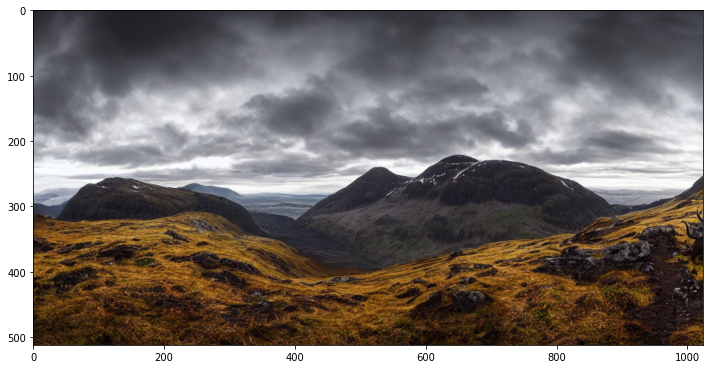

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio

mpl.rcParams['figure.figsize'] = (12, 8)

img = torch.FloatTensor(imageio.imread('./DiffusionFastForward/imgs/hills_2.png')/255)
plt.imshow(img)

### Before we start...
The majority of the diffusion models assume that the images are scaled to the `[-1,+1]` range (which tends to simplify many equations). This tutorial will follow the same approach, so we need to define input and output transformation functions `input_T()` and `output_T()`.

Also, let's define our own `show()` wrapper function that displays the image with automatic output transformation!

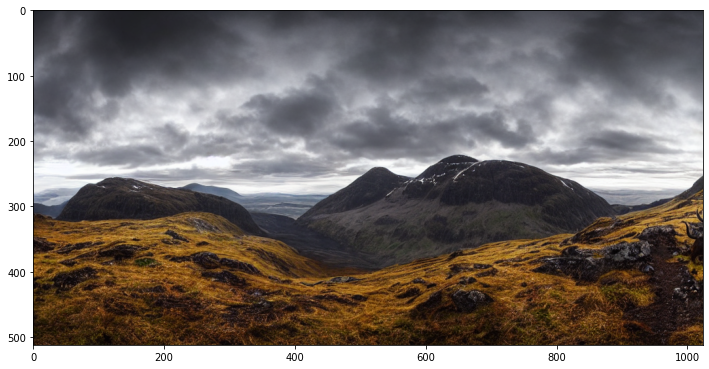

In [10]:
def input_T(input):
    # [0,1] -> [-1,+1]
    return 2*input-1
    
def output_T(input):
    # [-1,+1] -> [0,1]
    return (input+1)/2

def show(input):
    plt.imshow(output_T(input).clip(0,1))
    
img_=input_T(img)
show(img_)

### Defining a schedule
The diffusion process is built based on a variance schedule, which determines the levels of added noise at each step of the process. To that end, our schedule is defined below, with the following quantities:

* `betas`:$\beta_t$ 


* `alphas`: $\alpha_t=1-\beta_t$


* `alphas_sqrt`:  $\sqrt{\alpha_t}$ 


* `alphas_prod`: $\bar{\alpha}_t=\prod_{i=0}^{t}\alpha_i$ 


* `alphas_prod_sqrt`: $\sqrt{\bar{\alpha}_t}$ 

In [6]:
num_timesteps=1000
betas=torch.linspace(1e-4,2e-2,num_timesteps)

alphas=1-betas
alphas_sqrt=alphas.sqrt()
alphas_cumprod=torch.cumprod(alphas,0)
alphas_cumprod_sqrt=alphas_cumprod.sqrt()

## Forward Process
The forward process $q$ determines how subsequent steps in the diffusion are derived (gradual distortion of the original sample $x_0$).

📃 First, let's bring up the key equations describing this process...

Basic format of the forward step:
$$q(x_t|x_{t−1}) := \mathcal{N}(x_t; \sqrt{1 − \beta_t}x_{t−1}, \beta_tI) \tag{1}$$

to step directly from $x_0$ to $x_t$:
$$q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha_t}}x_0, (1 − \bar{\alpha_t})I) \tag{2}$$

### Let's define a function `forward_step()` that will allow us to use both $q(x_t|x_{t-1})$ and  `forward_jump()` for $q(x_t|x_0)$

In [7]:
def forward_step(t, condition_img, return_noise=False):
    """
        forward step: t-1 -> t
    """    
    assert t >= 0

    mean=alphas_sqrt[t]*condition_img    
    std=betas[t].sqrt()
      
    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise
    
def forward_jump(t, condition_img, condition_idx=0, return_noise=False):
    """
        forward jump: 0 -> t
    """   
    assert t >= 0
    
    mean=alphas_cumprod_sqrt[t]*condition_img
    std=(1-alphas_cumprod[t]).sqrt()
      
    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise

In [8]:
N=5 # number of computed states between x_0 and x_T
M=4 # number of samples taken from each distribution

In the first example, when `t==0`, we want to derive a sample $x_t$ based on the clean sample $x_0$!

The first column shows the mean image for a given stage of the diffusion, and the subsequent columns to the right show several samples taken from the same distribution (they are different if you look closely!).

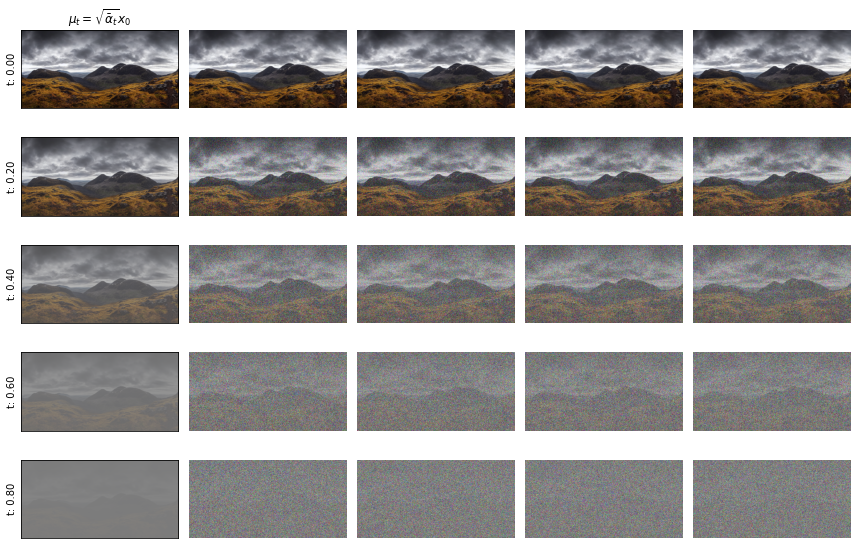

In [11]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))
    
    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_cumprod_sqrt[t_step]*img_)
    plt.title(r'$\mu_t=\sqrt{\bar{\alpha}_t}x_0$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])
    
    for sample in range(M):
        x_t=forward_jump(t_step,img_)
        
        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        show(x_t)        
        plt.axis('off')
        
plt.tight_layout()

Alternatively, we can test the process of going from $x_{t-1}$ to $x_t$, which is a single step in the diffusion process. For that we can use the `forward_step` function.

Note that the mean $\mu_t$ is now a bit different (first column) since it is conditioned on a specific sample of $x_{t-1}$!

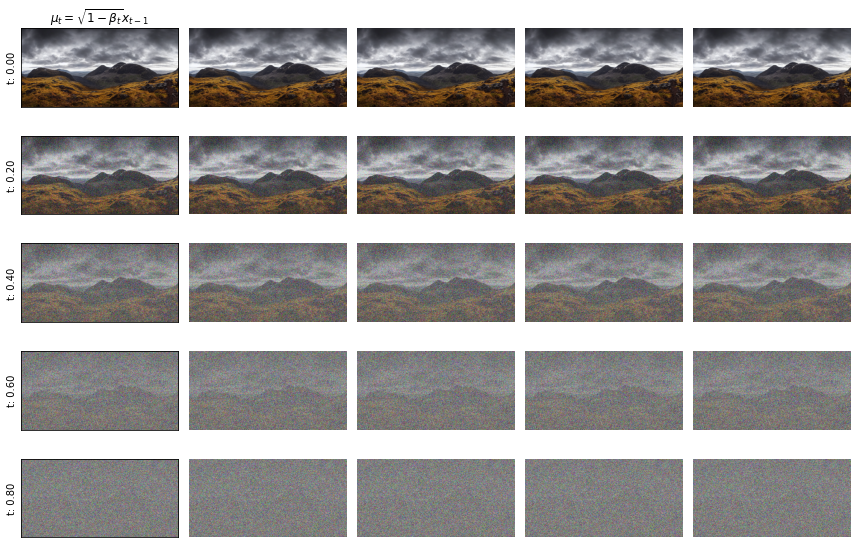

In [12]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))
    prev_img=forward_jump(max([0,t_step-1]),img_) # directly go to prev state
    
    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_sqrt[t_step]*prev_img)
    plt.title(r'$\mu_t=\sqrt{1-\beta_t}x_{t-1}$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])
    
    for sample in range(M):
        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        x_t=forward_step(t_step,prev_img)
        show(x_t)        
        plt.axis('off')
plt.tight_layout()

## Reverse Process

The purpose of the reverse process $p$ is to approximate the previous step $x_{t-1}$ in the diffusion chain based on a sample $x_t$. In practice, this approximation $p(x_{t-1}|x_t)$ must be done without the knowledge of $x_0$.

A parametrizable prediction model with parameters $\theta$ is used to estimate $p_\theta(x_{t-1}|x_t)$.

The reverse process will also be (approximately) gaussian if the diffusion steps are small enough:

$$p_\theta(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\mu_\theta(x_t),\Sigma_\theta(x_t))\tag{3}$$

In many works, it is assumed that the variance of this distribution should not depend strongly on $x_0$ or $x_t$, but rather on the stage of the diffusion process $t$. This can be observed in the true distribution $q(x_{t-1}|x_t, x_0)$, where the variance of the distribution equals $\tilde{\beta}_t$.

### Parameterizing $\mu_\theta$
There are at least 3 ways of parameterizing the mean of the reverse step distirbution $p_\theta(x_{t-1}|x_t)$:
* Directly (a neural network will estimate $\mu_\theta$)
* Via $x_0$ (a neural network will estimate $x_0$)
$$\tilde{\mu}_\theta = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t\tag{4}$$
* Via noise $\epsilon$ subtraction from $x_0$ (a neural network will estimate $\epsilon$)
$$x_0=\frac{1}{\sqrt{\bar{\alpha}_t}}(x_t-\sqrt{1-\bar{\alpha}_t}\epsilon)\tag{5}$$

The approach of approximating the normal noise $\epsilon$ is used most widely.

Let's look at what an example $\epsilon$ might look like:

(-0.5, 1023.5, 511.5, -0.5)

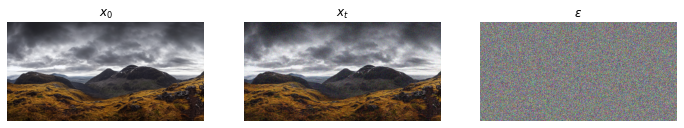

In [13]:
t_step=50

x_t,noise=forward_jump(t_step,img_,return_noise=True)

plt.subplot(1,3,1)
show(img_)
plt.title(r'$x_0$')
plt.axis('off')
plt.subplot(1,3,2)
show(x_t)
plt.title(r'$x_t$')
plt.axis('off')
plt.subplot(1,3,3)
show(noise)
plt.title(r'$\epsilon$')
plt.axis('off')

If $\epsilon$ is predicted correctly, we can use the equation (4) to predict $x_0$:

(-0.5, 1023.5, 511.5, -0.5)

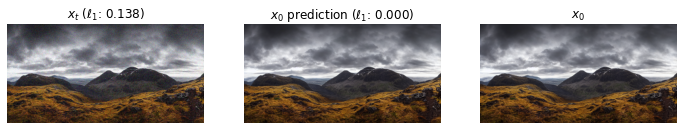

In [14]:
x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*noise)/(alphas_cumprod_sqrt[t_step])

plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$ ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.axis('off')
plt.subplot(1,3,2)
show(x_0_pred)
plt.title('$x_0$ prediction ($\ell_1$: {:.3f})'.format(F.l1_loss(x_0_pred,img_)))
plt.axis('off') 
plt.subplot(1,3,3)
show(img_)
plt.title('$x_0$')
plt.axis('off')

Approximation (or knowledge) of $x_0$ allows us to approximate the mean of the step $t-1$, using (5).

In [15]:
# estimate mean
mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

# let's compare it to ground truth mean of the previous step (requires knowledge of x_0)
mean_gt=alphas_cumprod_sqrt[t_step-1]*img_

Since reverse process mean estimation $\tilde{\mu}_\theta$ in (5) is effectively linear interpolation between noisy $x_t$ and $x_0$ it is expected to have a higher error (as the additive noise is still present) compared to the mean computed using the forward process (which is computed by scaling the clean sample by a scalar value).

Text(0.5, 1.0, '$\\mu_{t-1}$  ($\\ell_1$: 0.007)')

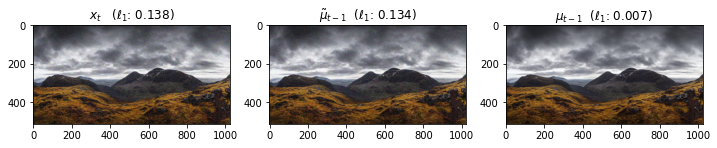

In [16]:
plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$   ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.subplot(1,3,2)
show(mean_pred)
plt.title(r'$\tilde{\mu}_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_pred,img_)))
plt.subplot(1,3,3)
show(mean_gt)
plt.title(r'$\mu_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_gt,img_)))

Once we get our `mean_pred` ($\tilde{\mu_{t}}$), we can define our distribution for the previous step

$$\tilde{\beta}_t=\beta_t \tag{6}$$

$$ p_\theta(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\tilde{\mu}_\theta(x_t,t),\tilde{\beta}_t I) \tag{7}$$

> Important: the experiment below should be treated as a simulation. In practice, the network must  predict either $\epsilon$ or $x_0$ or $\tilde{\mu}_\theta$. Here, the value of $epsilon$ is simply subs

In [17]:
def reverse_step(epsilon, x_t, t_step, return_noise=False):
    
    # estimate x_0 based on epsilon
    x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*epsilon)/(alphas_cumprod_sqrt[t_step])
    if t_step==0:
        sample=x_0_pred
        noise=torch.zeros_like(x_0_pred)
    else:
        # estimate mean
        mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

        # compute variance
        beta_pred=betas[t_step].sqrt() if t_step != 0 else 0

        sample=mean_pred+beta_pred*torch.randn_like(x_t)
        # this noise is only computed for simulation purposes (since x_0_pred is not known normally)
        noise=(sample-x_0_pred*alphas_cumprod_sqrt[t_step-1])/(1-alphas_cumprod[t_step-1]).sqrt()
    if return_noise:
        return sample, noise
    else:
        return sample

In [18]:
x_t,noise=forward_jump(1000-1,img_,return_noise=True)

state_imgs=[x_t.numpy()]
for t_step in reversed(range(1000)):
    x_t,noise=reverse_step(noise,x_t,t_step,return_noise=True)
    
    if t_step % 200 == 0:
        state_imgs.append(x_t.numpy())

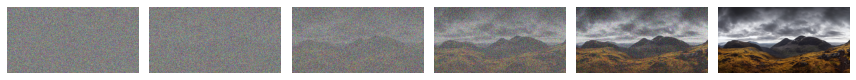

In [28]:
plt.figure()
for idx,state_img in enumerate(state_imgs):
    plt.subplot(1,len(state_imgs),idx+1)
    show(state_img.clip(-1,1))
    plt.axis('off')
    
plt.tight_layout()

## Packaging into Components
The processes investigated above are neatly packaged into modular components for easier management of the diffusion framework.

First, the forward process component `GaussianForwardProcess` encapsulates the functions of $q(x_t|x_0)$ and $q(x_t|x_{t-1})$.

Below, we can see how different schedules of the variance parameter $\beta$ affect how the noise level changes throughout the progression.

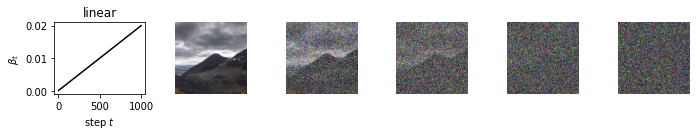

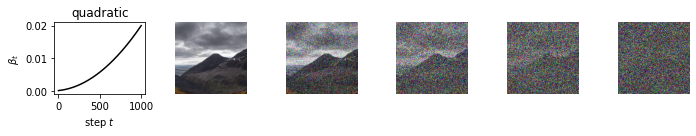

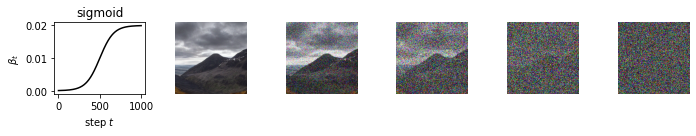

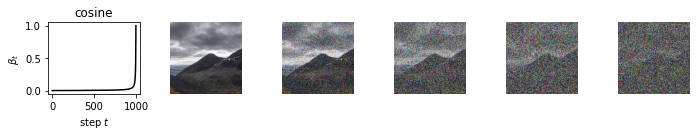

In [30]:
from src import *

D=128
make_white=False
save=False
line_color='black' #'#9EFFB9'
test_img=img[256-D:256+D,512-D:512+D,:]

for schedule in ['linear','quadratic','sigmoid','cosine']:
    fw=GaussianForwardProcess(1000,
                              schedule)

    plt.figure(figsize=(10,2))
    plt.subplot(1,6,1)    
    plt.plot(fw.betas,color=line_color)
    plt.title(schedule,color=line_color)
    plt.xlabel(r'step $t$',color=line_color)
    plt.ylabel(r'$\beta_t$',color=line_color)
    
    if make_white:
        plt.xticks(color='white')
        plt.gca().tick_params(axis='x', colors='white')
        plt.gca().tick_params(axis='y', colors='white')
        plt.gca().spines['top'].set_color('white')
        plt.gca().spines['right'].set_color('white')
        plt.gca().spines['left'].set_color('white')
        plt.gca().spines['bottom'].set_color('white')
    for step in range(5):
        plt.subplot(1,6,step+2)
        plt.imshow(fw(test_img.permute(2,0,1).unsqueeze(0),torch.tensor(step*200))[0].permute(1,2,0))
        plt.axis('off')        
    plt.tight_layout()
    
    
    if save:
        plt.savefig('{}.png'.format(schedule),
                    dpi=200,
                    bbox_inches='tight',
                    pad_inches=0.0,
                    transparent=True)